In [43]:
import numpy as np
import matplotlib.pyplot as plt

In [44]:
# Load data
data_A = np.genfromtxt('data/DetectorA.csv', delimiter=',', skip_header=1).T
data_B = np.genfromtxt('data/DetectorB.csv', delimiter=',', skip_header=1).T
data_C = np.genfromtxt('data/DetectorC.csv', delimiter=',', skip_header=1).T
data_Target = np.genfromtxt('data/DetectorTarget.csv', delimiter=',', skip_header=1).T

In [45]:
# Score
score_A = data_A[1]
score_B = data_B[1]
score_C = data_C[1]
score_Target = data_Target[1]

# Energy
energy_A = data_A[2]
energy_B = data_B[2]
energy_C = data_C[2]
energy_Target = data_Target[2]


In [46]:
# Set limits
energy_upper_limit = 3500
energy_lower_limit = 1000

score_A = score_A[energy_A < energy_upper_limit]
score_B = score_B[energy_B < energy_upper_limit]
score_C = score_C[energy_C < energy_upper_limit]
score_Target = score_Target[energy_Target < energy_upper_limit]

energy_A = energy_A[energy_A < energy_upper_limit]
energy_B = energy_B[energy_B < energy_upper_limit]
energy_C = energy_C[energy_C < energy_upper_limit]
energy_Target = energy_Target[energy_Target < energy_upper_limit]

(1000.0, 3505.0)

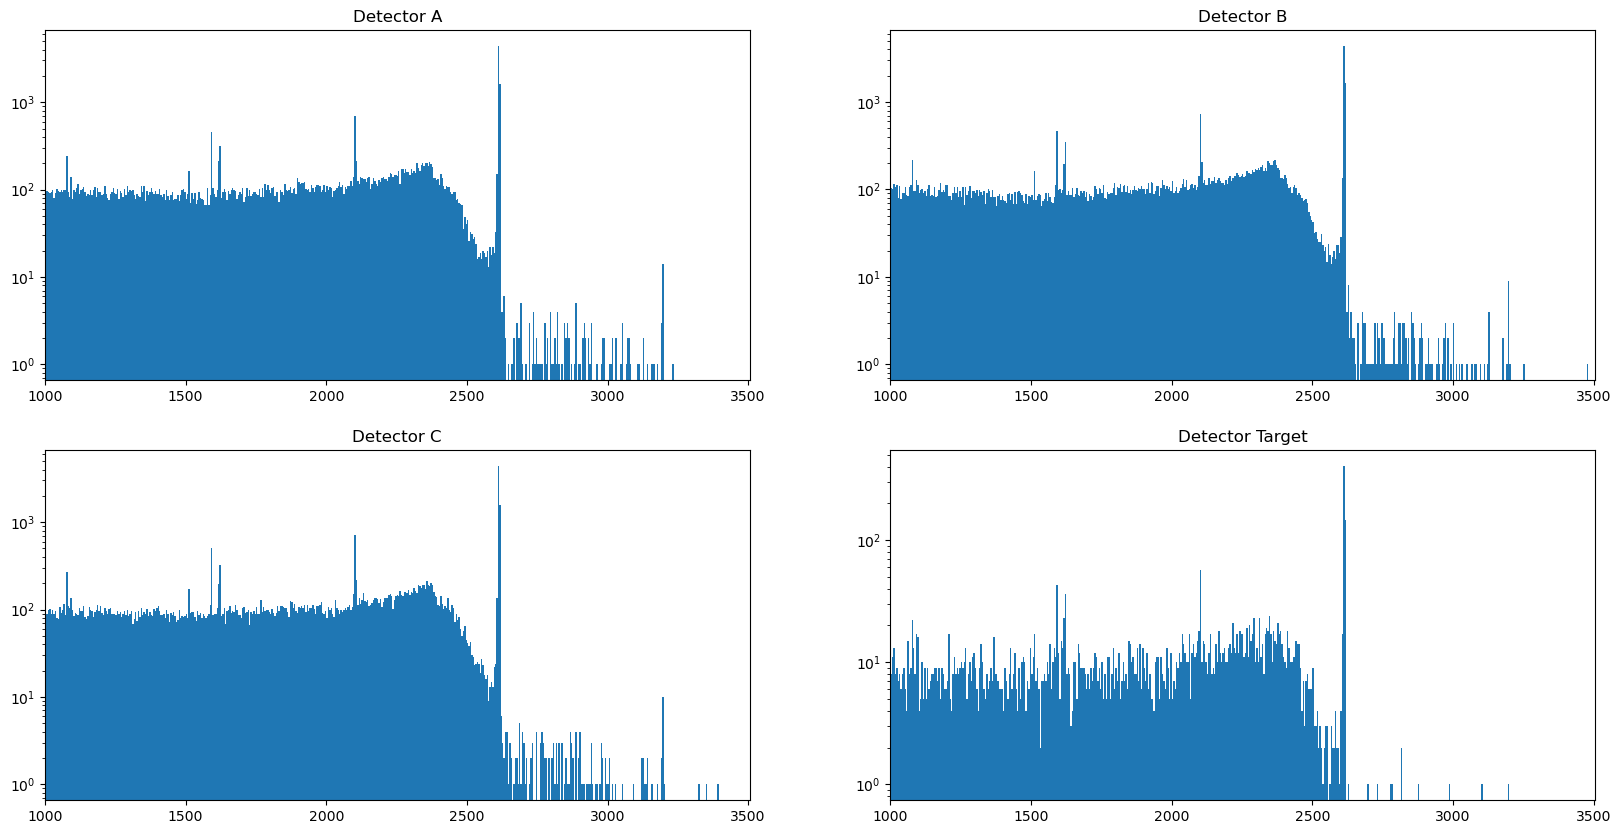

In [47]:
# Create histograms
bin_width = 5
hist_A, bins_A = np.histogram(energy_A, bins=np.arange(energy_lower_limit, energy_upper_limit + bin_width, bin_width))
hist_B, bins_B = np.histogram(energy_B, bins=np.arange(energy_lower_limit, energy_upper_limit + bin_width, bin_width))
hist_C, bins_C = np.histogram(energy_C, bins=np.arange(energy_lower_limit, energy_upper_limit + bin_width, bin_width))
hist_Target, bins_Target = np.histogram(energy_Target, bins=np.arange(energy_lower_limit, energy_upper_limit + bin_width, bin_width))

fig, axes = plt.subplots(2, 2, figsize=(20, 10))

axes[0, 0].set_title('Detector A')
axes[0, 0].stairs(hist_A, bins_A, label='Detector A', fill=True)
axes[0, 0].set_yscale('log')
axes[0, 0].set_xlim(energy_lower_limit, energy_upper_limit + bin_width)

axes[0, 1].set_title('Detector B')
axes[0, 1].stairs(hist_B, bins_B, label='Detector B', fill=True)
axes[0, 1].set_yscale('log')
axes[0, 1].set_xlim(energy_lower_limit, energy_upper_limit + bin_width)

axes[1, 0].set_title('Detector C')
axes[1, 0].stairs(hist_C, bins_C, label='Detector C', fill=True)
axes[1, 0].set_yscale('log')
axes[1, 0].set_xlim(energy_lower_limit, energy_upper_limit + bin_width)

axes[1, 1].set_title('Detector Target')
axes[1, 1].stairs(hist_Target, bins_Target, label='Detector Target', fill=True)
axes[1, 1].set_yscale('log')
axes[1, 1].set_xlim(energy_lower_limit, energy_upper_limit + bin_width)


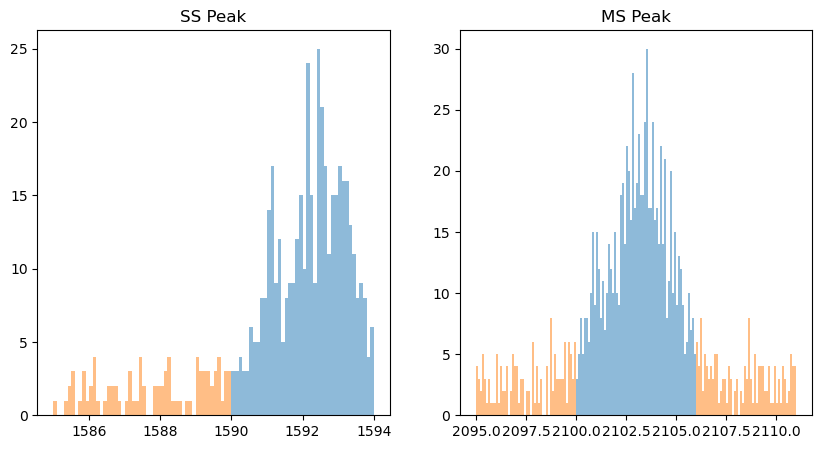

In [48]:
# Range of SS peak
ss_lower_limit = 1590
ss_upper_limit = 1594

# Range of MS peak
ms_lower_limit = 2100
ms_upper_limit = 2106

# Range of SS baseline
ss_baseline_lower_limit = 1585

# Range of MS baseline
ms_baseline_lower_limit = 2095
ms_baseline_upper_limit = 2111

ss = energy_A[(energy_A > ss_lower_limit) & (energy_A < ss_upper_limit)]
ms = energy_B[(energy_B > ms_lower_limit) & (energy_B < ms_upper_limit)]

ss_baseline = energy_A[(energy_A > ss_baseline_lower_limit) & (energy_A < ss_lower_limit)]
ms_baseline = energy_B[((energy_B > ms_baseline_lower_limit) & (energy_B < ms_lower_limit)) | ((energy_B > ms_upper_limit) & (energy_B < ms_baseline_upper_limit))]

bin_width_peaks = 0.1

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].set_title('SS Peak')
_ = axes[0].hist(ss, bins=np.arange(ss_lower_limit, ss_upper_limit + bin_width_peaks, bin_width_peaks), alpha=0.5, label='Peak')
_ = axes[0].hist(ss_baseline, bins=np.arange(ss_baseline_lower_limit, ss_lower_limit + bin_width_peaks, bin_width_peaks), alpha=0.5, label='Baseline')

axes[1].set_title('MS Peak')
_ = axes[1].hist(ms, bins=np.arange(ms_lower_limit, ms_upper_limit + bin_width_peaks, bin_width_peaks), alpha=0.5, label='Peak')
_ = axes[1].hist(ms_baseline, bins=np.arange(ms_baseline_lower_limit, ms_baseline_upper_limit + bin_width_peaks, bin_width_peaks), alpha=0.5, label='Baseline')

In [49]:
ss_score = score_A[(energy_A > ss_lower_limit) & (energy_A < ss_upper_limit)]
ms_score = score_B[(energy_B > ms_lower_limit) & (energy_B < ms_upper_limit)]

ss_baseline_score = score_A[(energy_A > ss_baseline_lower_limit) & (energy_A < ss_lower_limit)]
ms_baseline_score = score_B[((energy_B > ms_baseline_lower_limit) & (energy_B < ms_lower_limit)) | ((energy_B > ms_upper_limit) & (energy_B < ms_baseline_upper_limit))]

Ns = ss.size
Bs = ss_baseline.size
Nb = ms.size
Bb = ms_baseline.size

# Return TPR, FPR
def metrics(threshold, tau_ss=1, tau_ms=0.5):
    Ntp = np.sum(ss_score > threshold)
    Bss = np.sum(ss_baseline_score > threshold)
    Nfp = np.sum(ms_score > threshold)
    Bms = np.sum(ms_baseline_score > threshold)
    return (Ntp - tau_ss * Bss) / (Ns - tau_ss * Bs), (Nfp - tau_ms * Bms) / (Nb - tau_ms * Bb)

# Try n thresholds
def roc(n=200):
    return np.array([metrics(t) for t in np.linspace(0, 1, n)])

# Plot ROC curve
def plot_roc(threshold):
    roc_curve = roc()
    selected = metrics(threshold)
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(roc_curve[:, 1], roc_curve[:, 0], label='ROC curve')
    ax.plot(selected[1], selected[0], 'ro', label='Selected threshold')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('ROC curve')
    print(f'Selected threshold: {threshold:.3f}')
    print(f'True positive rate: {selected[0]:.2f}')
    print(f'False positive rate: {selected[1]:.2f}')
    plt.legend()

In [50]:
import ipywidgets as widgets

widgets.interact(plot_roc, 
         threshold=widgets.FloatSlider(min=0, max=1, step=0.005, value=0.5, layout=widgets.Layout(width='50%')))

interactive(children=(FloatSlider(value=0.5, description='threshold', layout=Layout(width='50%'), max=1.0, ste…

<function __main__.plot_roc(threshold)>

In [51]:
# Final selection
selected_threshold = 0.085

selected_energy_A = energy_A[score_A > selected_threshold]
selected_energy_B = energy_B[score_B > selected_threshold]
selected_energy_C = energy_C[score_C > selected_threshold]
selected_energy_Target = energy_Target[score_Target > selected_threshold]

selected_hist_A, selected_bins_A = np.histogram(selected_energy_A, bins=np.arange(energy_lower_limit, energy_upper_limit + bin_width, bin_width))
selected_hist_B, selected_bins_B = np.histogram(selected_energy_B, bins=np.arange(energy_lower_limit, energy_upper_limit + bin_width, bin_width))
selected_hist_C, selected_bins_C = np.histogram(selected_energy_C, bins=np.arange(energy_lower_limit, energy_upper_limit + bin_width, bin_width))
selected_hist_Target, selected_bins_Target = np.histogram(selected_energy_Target, bins=np.arange(energy_lower_limit, energy_upper_limit + bin_width, bin_width))

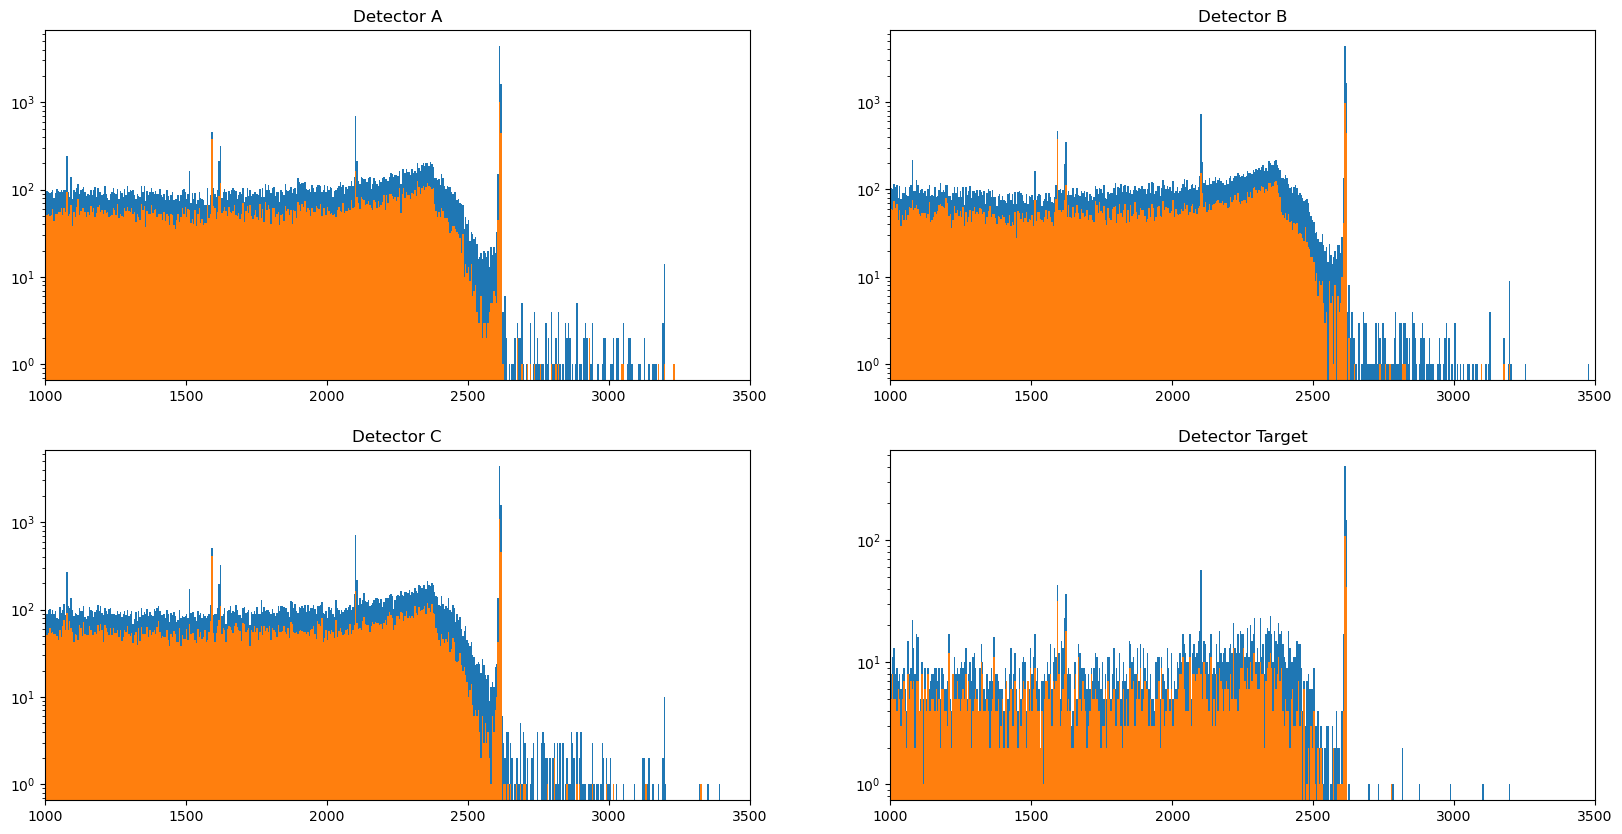

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

axes[0, 0].set_title('Detector A')
axes[0, 0].stairs(hist_A, bins_A, label='Detector A', fill=True)
axes[0, 0].stairs(selected_hist_A, selected_bins_A, label='Detector A', fill=True)
axes[0, 0].set_yscale('log')
axes[0, 0].set_xlim(energy_lower_limit, energy_upper_limit)

axes[0, 1].set_title('Detector B')
axes[0, 1].stairs(hist_B, bins_B, label='Detector B', fill=True)
axes[0, 1].stairs(selected_hist_B, selected_bins_B, label='Detector B', fill=True)
axes[0, 1].set_yscale('log')
axes[0, 1].set_xlim(energy_lower_limit, energy_upper_limit)

axes[1, 0].set_title('Detector C')
axes[1, 0].stairs(hist_C, bins_C, label='Detector C', fill=True)
axes[1, 0].stairs(selected_hist_C, selected_bins_C, label='Detector C', fill=True)
axes[1, 0].set_yscale('log')
axes[1, 0].set_xlim(energy_lower_limit, energy_upper_limit)

axes[1, 1].set_title('Detector Target')
axes[1, 1].stairs(hist_Target, bins_Target, label='Detector Target', fill=True)
axes[1, 1].stairs(selected_hist_Target, selected_bins_Target, label='Detector Target', fill=True)
axes[1, 1].set_yscale('log')
axes[1, 1].set_xlim(energy_lower_limit, energy_upper_limit)

plt.show()


In [53]:
from scipy.integrate import quad

# Gaussian function
def gaussian(x, mu, sigma):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma)**2)

# Generate NLDBD PDF
mu = 2039
sigma = 1
bins_N = np.arange(energy_lower_limit, energy_upper_limit + bin_width, bin_width)
pdf_N = np.array([quad(gaussian, bins_N[i], bins_N[i+1], args=(mu, sigma))[0] for i in range(len(bins_N)-1)])

In [54]:
sum(pdf_N)

np.float64(1.0)

In [55]:
# Normalize histograms to get PDFs
pdf_A = selected_hist_A / np.sum(selected_hist_A)
pdf_B = selected_hist_B / np.sum(selected_hist_B)
pdf_C = selected_hist_C / np.sum(selected_hist_C)

In [56]:
sum(pdf_A), sum(pdf_B), sum(pdf_C)

(np.float64(1.0),
 np.float64(0.9999999999999993),
 np.float64(1.0000000000000004))

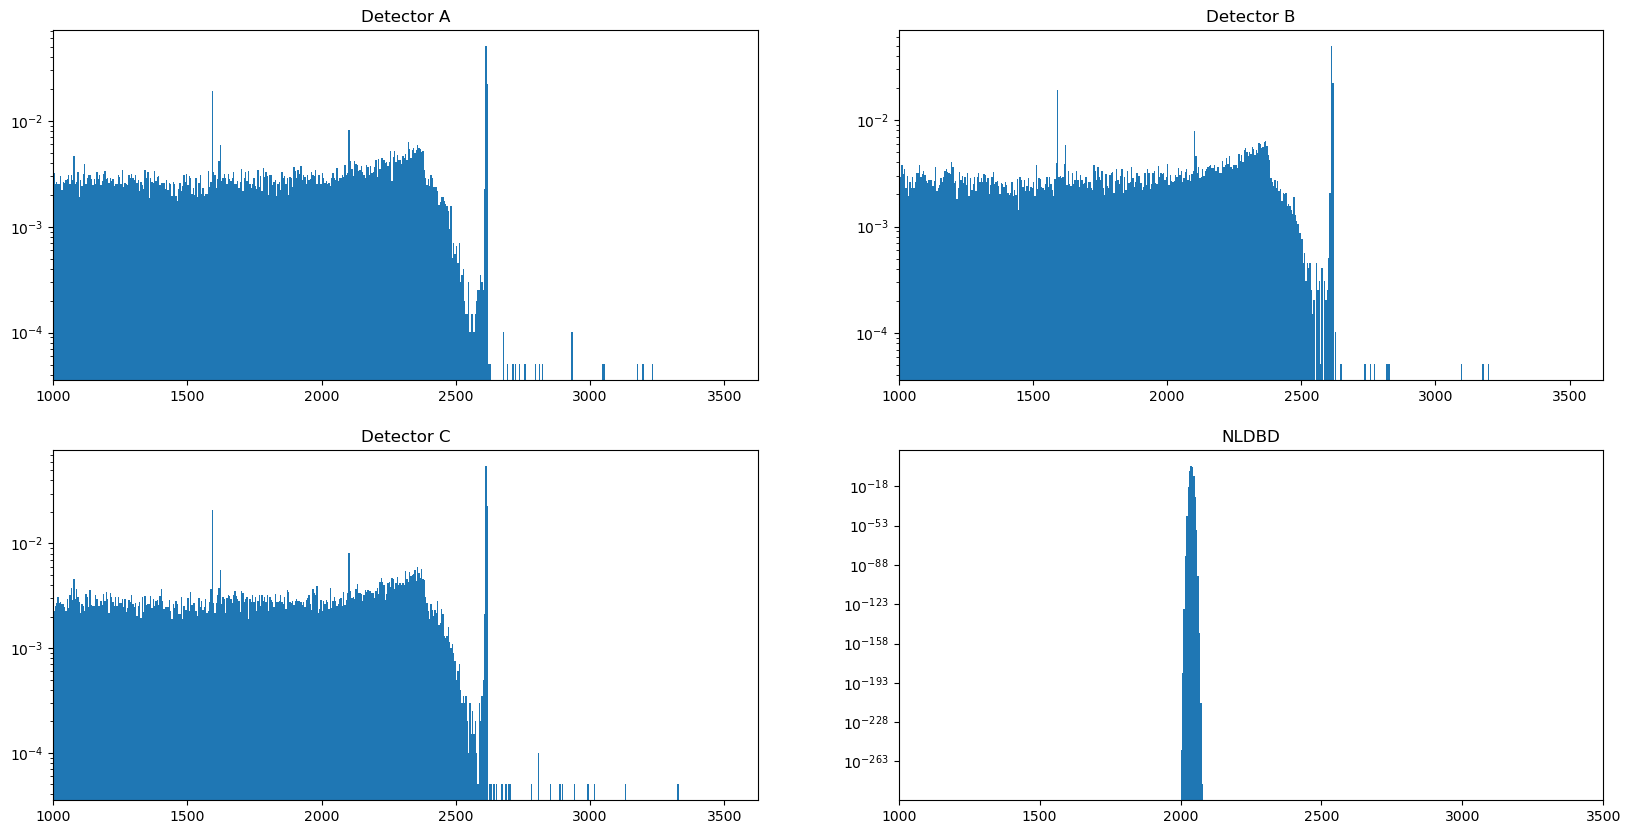

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes[0, 0].set_title('Detector A')
axes[0, 0].stairs(pdf_A, bins_A, label='Detector A', fill=True)
axes[0, 0].set_yscale('log')
axes[0, 0].set_xlim(1000)

axes[0, 1].set_title('Detector B')
axes[0, 1].stairs(pdf_B, bins_B, label='Detector B', fill=True)
axes[0, 1].set_yscale('log')
axes[0, 1].set_xlim(1000)

axes[1, 0].set_title('Detector C')
axes[1, 0].stairs(pdf_C, bins_C, label='Detector C', fill=True)
axes[1, 0].set_yscale('log')
axes[1, 0].set_xlim(1000)

axes[1, 1].set_title('NLDBD')
axes[1, 1].stairs(pdf_N, bins_N, label='NLDBD', fill=True)
axes[1, 1].set_yscale('log')
axes[1, 1].set_xlim(1000, energy_upper_limit)

plt.show()

In [ ]:
# theta = [theta_A, theta_B, theta_C, theta_N]
def hypothesis(theta):
    return theta[0] * pdf_A + theta[1] * pdf_B + theta[2] * pdf_C + theta[3] * pdf_N

def log_likelihood(theta, target_hist):
    mu = hypothesis(theta)
    non_zero_bins = target_hist[(target_hist > 0) & (mu > 0)]
    non_zero_bins_mu = mu[(target_hist > 0) & (mu > 0)]
    zero_bins_mu = mu[~(target_hist > 0) & ~(mu > 0)]
        
    return np.sum(non_zero_bins * np.log(non_zero_bins_mu) - non_zero_bins_mu - non_zero_bins * np.log(non_zero_bins) + non_zero_bins) - np.sum(zero_bins_mu)

def log_prior(theta):
    # Use Gaussian prior for theta_A and theta_B, Jeffreys prior for Poisson distribution for theta_C and theta_N
    prior = np.log(gaussian(theta[0], 1350, 100)) + np.log(gaussian(theta[1], 770, 270)) - np.log(theta[2]) / 2 - np.log(theta[3]) / 2
    return prior

def log_posterior(theta, target_hist):
    # Use the log-likelihood and log-prior to compute the log-posterior
    posterior = log_likelihood(theta, target_hist) + log_prior(theta)
    if np.any(theta < 0):
        return -np.inf
    return posterior

In [59]:
sum(selected_hist_Target)

np.int64(1838)

In [60]:
theta_min = 0
theta_max = 3000

In [61]:
from scipy.optimize import minimize

theta_initial = np.array([1350, 770, 1000, 1000])
theta_est = minimize(lambda theta: -log_posterior(theta, selected_hist_Target), theta_initial, bounds=[(0, 3000), (0, 3000), (0, 3000), (0, 3000)]).x


C:\Users\hdhoa\AppData\Local\Temp\ipykernel_2664\928682982.py:15: RuntimeWarning: divide by zero encountered in log
  prior = np.log(gaussian(theta[0], 1350, 100)) + np.log(gaussian(theta[1], 770, 270)) - np.log(theta[2]) / 2 - np.log(theta[3]) / 2
c:\Users\hdhoa\miniconda3\envs\dsc291\Lib\site-packages\scipy\optimize\_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


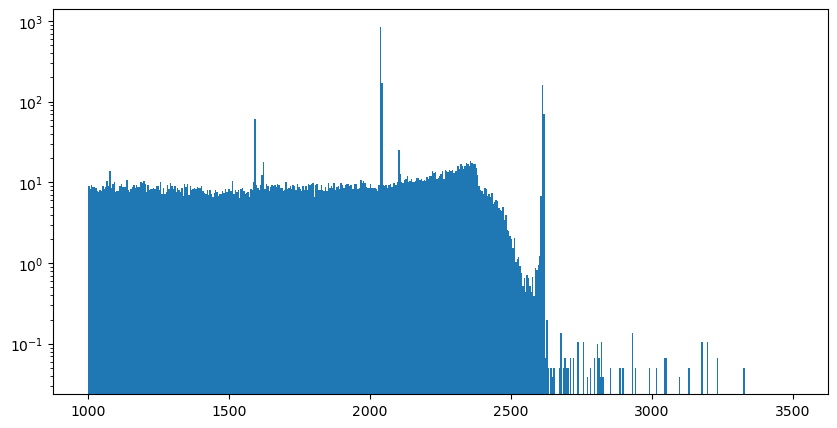

In [62]:
plt.figure(figsize=(10, 5))
plt.stairs(hypothesis(theta_est), bins_Target, label='Hypothesis', fill=True)
plt.yscale('log')

In [63]:
theta_est

array([1349.58913142,  769.59127341,  999.59156899,  999.01601846])

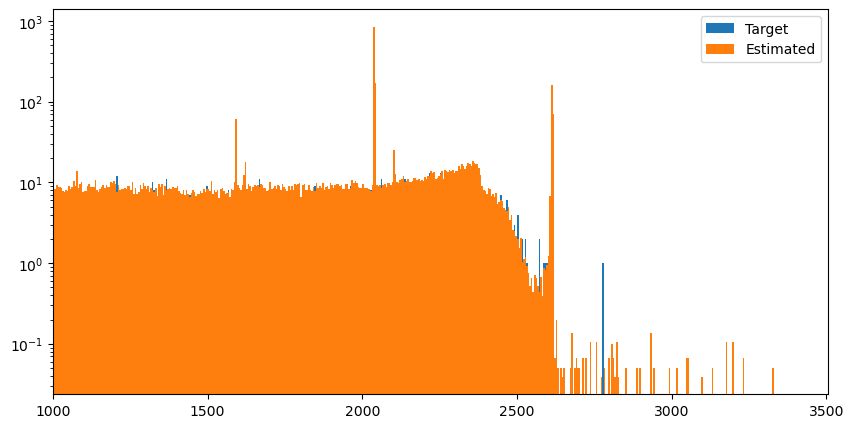

In [64]:
result_hist = hypothesis(theta_est)
plt.figure(figsize=(10, 5))
plt.stairs(selected_hist_Target, bins_Target, label='Target', fill=True)
plt.stairs(result_hist, bins_Target, label='Estimated', fill=True)
plt.yscale('log')
plt.xlim(energy_lower_limit, energy_upper_limit + bin_width)
plt.legend()


In [65]:
import emcee

n_walkers = 100
initial_theta = theta_est + 0.1 * np.random.randn(n_walkers, len(theta_est))

sampler = emcee.EnsembleSampler(n_walkers, len(theta_est), log_posterior, args=[selected_hist_Target])

In [66]:
sampler.run_mcmc(initial_theta, 5000, progress=True)

  0%|          | 0/5000 [00:00<?, ?it/s]C:\Users\hdhoa\AppData\Local\Temp\ipykernel_2664\928682982.py:15: RuntimeWarning: invalid value encountered in log
  prior = np.log(gaussian(theta[0], 1350, 100)) + np.log(gaussian(theta[1], 770, 270)) - np.log(theta[2]) / 2 - np.log(theta[3]) / 2
100%|██████████| 5000/5000 [00:13<00:00, 362.20it/s]


State([[1.19053382e+03 4.13673061e+02 2.80726747e+02 1.80447246e+01]
 [1.09787438e+03 4.66382517e+02 2.49056013e+02 2.74725287e+00]
 [1.30243314e+03 5.19986719e+02 8.88544811e-01 5.76411502e+00]
 [1.25501486e+03 5.64444287e+02 6.92040710e+01 9.61756969e+00]
 [1.18773736e+03 3.57762742e+02 3.47593778e+02 8.64599544e+00]
 [1.19925235e+03 2.46729894e+02 4.04423272e+02 9.28296761e+00]
 [1.18657499e+03 5.04927364e+02 1.83004113e+02 5.67610387e+00]
 [1.23728350e+03 3.61299566e+02 2.72429932e+02 9.02145449e+00]
 [1.41039286e+03 3.40353642e+02 1.53109280e+02 2.90811985e+00]
 [1.31394630e+03 5.24345912e+02 5.55516602e+01 1.17637460e+01]
 [1.24389492e+03 4.96308426e+02 1.08693154e+02 9.67544276e+00]
 [1.10884429e+03 5.13486674e+02 1.79736123e+02 1.25640594e+01]
 [1.26743823e+03 5.07675396e+02 1.67526276e+01 4.30497967e+00]
 [1.40462559e+03 2.63097492e+02 2.19680670e+02 1.80258952e+00]
 [1.37127984e+03 4.93442797e+02 2.28093009e+00 9.14241041e+00]
 [1.22841425e+03 1.61200546e+02 4.48211550e+02 7.

Text(0.5, 0, 'step number')

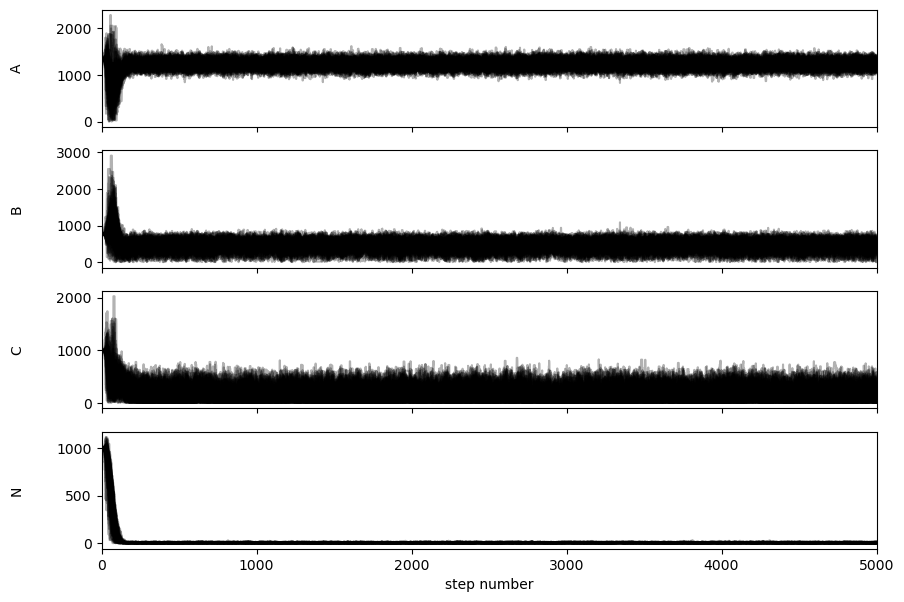

In [67]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["A", "B", "C", "N"]
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [68]:
tau = sampler.get_autocorr_time()
print(tau)

[60.24646972 66.84737422 86.17977568 80.99837166]


In [69]:
flat_samples = sampler.get_chain(discard=200, flat=True)
print(flat_samples.shape)

(480000, 4)


In [70]:
from IPython.display import display, Math

result = []
for i in range(4):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    result.append(mcmc[1])
    display(Math(txt))

<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
C:\Users\hdhoa\AppData\Local\Temp\ipykernel_2664\4193384631.py:7: SyntaxWarning: invalid escape sequence '\m'
  txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [71]:
result

[np.float64(1233.991488541666),
 np.float64(492.69596176271364),
 np.float64(115.05919277741711),
 np.float64(5.748007791335429)]

(1000.0, 3505.0)

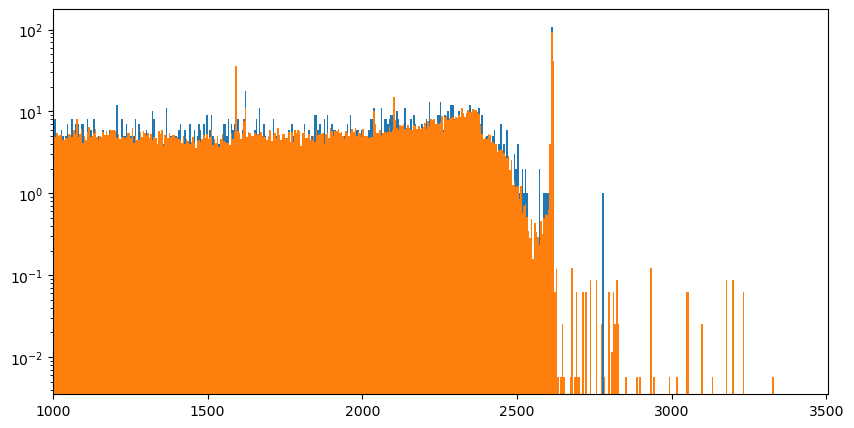

In [72]:
fitted_hist = hypothesis(result)
plt.figure(figsize=(10, 5))
plt.stairs(selected_hist_Target, bins_Target, label='Target', fill=True)
plt.stairs(fitted_hist, bins_Target, label='Fitted', fill=True)
plt.yscale('log')
plt.xlim(energy_lower_limit, energy_upper_limit + bin_width)


(0.0, 25.0)

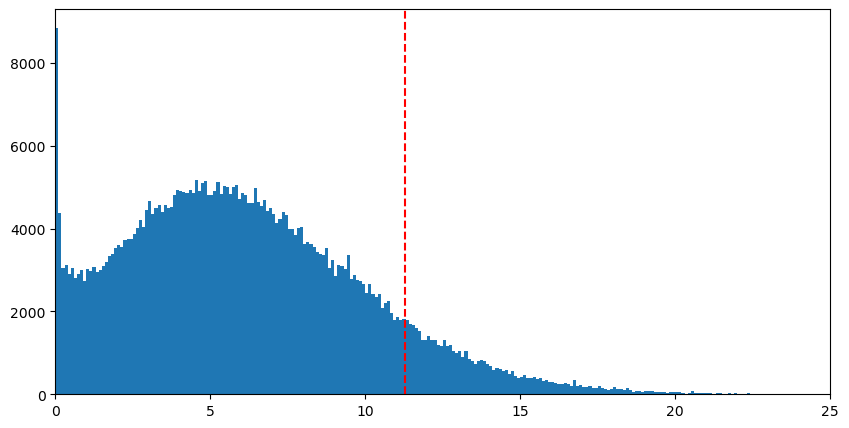

In [73]:
CI = np.percentile(flat_samples[:, 3], 90)
theta_N_hist, theta_N_bins = np.histogram(flat_samples[:, 3], bins=np.arange(0, 25, 0.1))
plt.figure(figsize=(10, 5))
plt.stairs(theta_N_hist, theta_N_bins, fill=True)
plt.axvline(CI, color='red', linestyle='--', label='90% CI')
plt.xlim(0, 25)

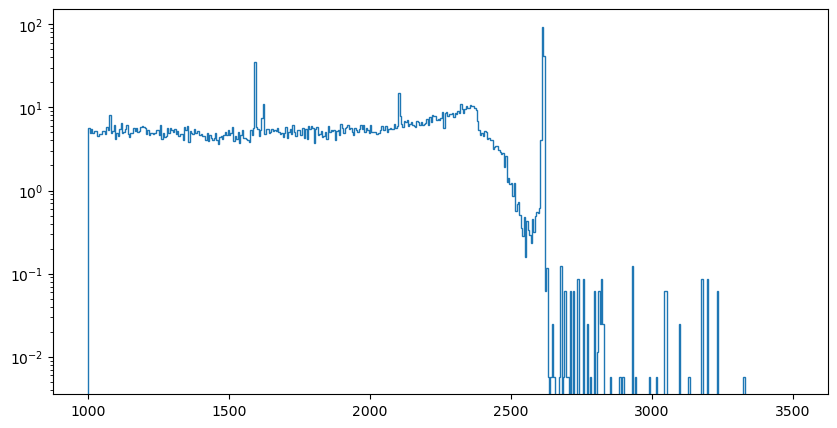

In [74]:
asimov_hist = result[0] * pdf_A + result[1] * pdf_B + result[2] * pdf_C

plt.figure(figsize=(10, 5))
plt.stairs(asimov_hist, bins_Target)
plt.yscale('log')
plt.show()

In [75]:
# new functions for asimov data
def hypothesis_asimov(theta):
    return result[0] * pdf_A + result[1] * pdf_B + result[2] * pdf_C + theta * pdf_N

def log_likelihood_asimov(theta, target_hist):
    mu = hypothesis_asimov(theta)
    non_zero_bins = target_hist[(target_hist > 0) & (mu > 0)]
    non_zero_bins_mu = mu[(target_hist > 0) & (mu > 0)]
    zero_bins_mu = mu[~(target_hist > 0) & ~(mu > 0)]
    return np.sum(non_zero_bins * np.log(non_zero_bins_mu) - non_zero_bins_mu - non_zero_bins * np.log(non_zero_bins) + non_zero_bins) - np.sum(zero_bins_mu)
    
def log_prior_asimov(theta):
    # Use Jeffreys prior for Poisson distribution for theta_N
    prior = - np.log(theta) / 2
    return prior

def log_posterior_asimov(theta, target_hist):
    # Use the log-likelihood and log-prior to compute the log-posterior
    posterior = log_likelihood_asimov(theta, target_hist) + log_prior_asimov(theta)
    if np.any(theta < 0):
        return -np.inf
    return posterior

In [76]:
# run mcmc on the asimov dataset
ovbb = 0
n_walkers = 100
initial_theta_asimov = ovbb + 0.1 * np.random.randn(n_walkers, 1)

sampler_asimov = emcee.EnsembleSampler(n_walkers, 1, log_posterior_asimov, args=[asimov_hist])

In [77]:
sampler_asimov.run_mcmc(initial_theta_asimov, 5000, progress=True)

C:\Users\hdhoa\AppData\Local\Temp\ipykernel_2664\2984133817.py:14: RuntimeWarning: invalid value encountered in log
  prior = - np.log(theta) / 2
100%|██████████| 5000/5000 [00:11<00:00, 424.03it/s]


State([[2.55069333e+00]
 [5.77201642e-03]
 [1.04842909e+00]
 [6.05206620e-01]
 [9.29445736e-01]
 [1.13507616e-02]
 [1.68208937e+00]
 [5.29692523e-01]
 [2.08812885e-01]
 [1.47523943e+00]
 [1.74462291e+00]
 [5.86564712e+00]
 [3.85565644e-01]
 [1.39118942e-02]
 [5.81117210e-01]
 [2.36608949e+00]
 [1.59344893e+00]
 [9.63135763e-02]
 [1.15960390e-01]
 [9.06914730e-01]
 [1.01367513e+00]
 [1.04975652e+00]
 [6.57416818e+00]
 [4.03289155e+00]
 [9.93587626e-02]
 [5.61305163e+00]
 [6.84166089e-01]
 [8.54635168e-02]
 [4.70988736e+00]
 [2.79165178e+00]
 [3.42325094e-01]
 [4.28301516e+00]
 [2.92286346e-01]
 [1.11698155e+00]
 [1.22207510e+00]
 [9.06457434e-02]
 [5.22953166e-01]
 [1.35601779e-01]
 [5.39734558e-01]
 [5.56083287e-01]
 [2.48516340e+00]
 [7.75393455e+00]
 [4.78787268e+00]
 [5.44520281e+00]
 [1.40850977e+00]
 [1.60700356e+00]
 [2.38020371e+00]
 [3.24831683e-02]
 [4.09019040e-01]
 [3.34445783e+00]
 [4.60816235e-02]
 [2.75080448e-01]
 [4.39682375e+00]
 [3.31319021e-01]
 [5.95897792e+00]
 [7.

Text(0.5, 0, 'step number')

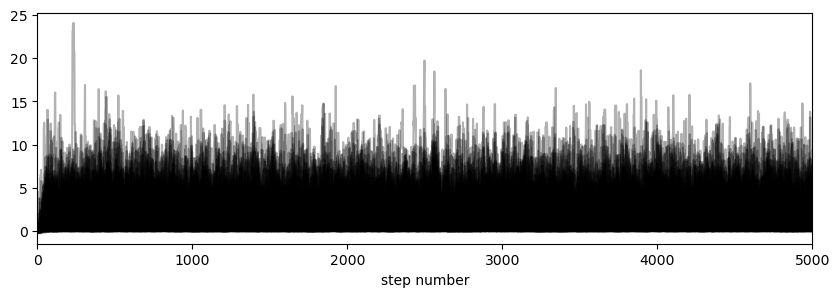

In [78]:
fig, axes = plt.subplots(1, figsize=(10, 3), sharex=True)
samples_asimov = sampler_asimov.get_chain()
labels = ["A", "B", "C", "N"]

ax = axes
ax.plot(samples_asimov[:, :, 0], "k", alpha=0.3)
ax.set_xlim(0, len(samples_asimov))
#ax.yaxis.set_label_coords(-0.1, 0.5)

axes.set_xlabel("step number")

In [79]:
sampler_asimov.get_autocorr_time()

array([43.97762686])

In [80]:
flat_samples_asimov = sampler_asimov.get_chain(discard=200, flat=True)
print(flat_samples_asimov.shape)

(480000, 1)


In [81]:
mcmc_asimov = np.percentile(flat_samples_asimov[:, 0], [16, 50, 84])
q = np.diff(mcmc_asimov)
txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
txt = txt.format(mcmc_asimov[1], q[0], q[1], 'N_{A}')
result_asimov = mcmc_asimov[1]
display(Math(txt))

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
C:\Users\hdhoa\AppData\Local\Temp\ipykernel_2664\2585125136.py:3: SyntaxWarning: invalid escape sequence '\m'
  txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"


<IPython.core.display.Math object>

In [82]:
ES = np.percentile(flat_samples_asimov[:, 0], 90)  # experimental sensitivity
CI = np.percentile(flat_samples[:, 3], 90)  # 90% credible interval
print(ES)
print(CI)

4.2741526213592484
11.285114449219385


(0.0, 25.0)

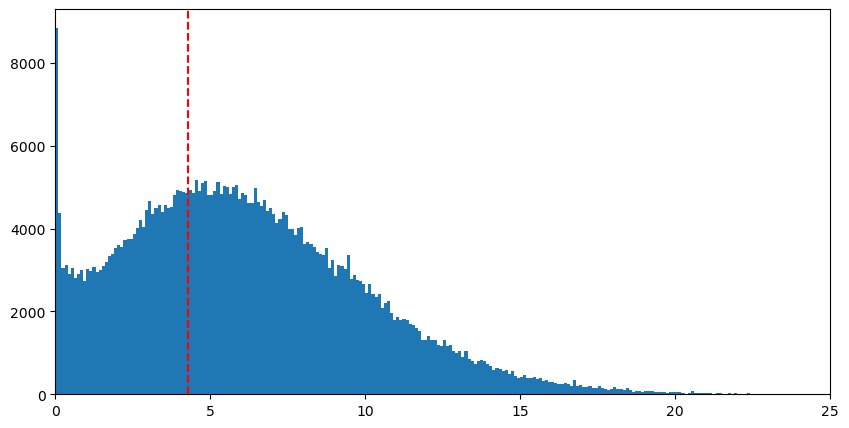

In [83]:
theta_N_hist_asimov, theta_N_bins_asimov = np.histogram(flat_samples_asimov, bins=np.arange(0, 25, 0.1))
plt.figure(figsize=(10, 5))
plt.stairs(theta_N_hist, theta_N_bins, fill=True)
plt.axvline(ES, color='red', linestyle='--', label='90% CI')
plt.xlim(0, 25)

In [86]:
TPR = metrics(selected_threshold)[0]
m = result[3] / TPR
m

np.float64(6.403318125852497)

"ES" is the experimental sensitivity, or 90% median sensitivity; "CI" is the Bayes 90% credible interval, or experimental confidence limit. Since our experimental confidence limit is greater than the 90% median sensitivity, we have overfluctuation, meaning we've obtained a stronger result (in practice) than the minimum detectable level [from the toy Asimov data, assuming no $0 \nu \beta \beta$ decay events]; given that some $m$ number of $0 \nu \beta \beta$ decay events have been artificially injected, this makes sense (and is expected, even).